In [1]:
from importlib.metadata import version

print("torch version:", version("torch"))

torch version: 2.1.1


In [2]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

## basically A.A(T) krr rhe wrt 2nd input token

In [7]:
query = inputs[1]

attn_scores_2 = torch.empty(inputs.shape[0])

for i, x_i in enumerate(inputs):

    attn_scores_2[i] = torch.dot(x_i, query)

print(attn_scores_2)

tensor([-7.9864e+28,  2.0613e-42,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00])
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


* Step 2: normalize the unnormalized attention scores ("omegas", 
) so that they sum up to 1
* Here is a simple way to normalize the unnormalized attention scores to sum up to 1 (a convention, useful for interpretation, and important for training stability):

In [11]:
attn_scores_2_tmp = attn_scores_2 / attn_scores_2.sum()
print(attn_scores_2_tmp)

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])



* However, in practice, using the softmax function for normalization, which is better at handling extreme values and has more desirable gradient properties during training, is common and recommended.
* Here's a naive implementation of a softmax function for scaling, which also normalizes the vector elements such that they sum up to 1:

In [10]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print(attn_weights_2_naive)

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])



* The naive implementation above can suffer from numerical instability issues for large or small input values due to overflow and underflow issues
* Hence, in practice, it's recommended to use the PyTorch implementation of softmax instead, which has been highly optimized for performance:

In [12]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print(attn_weights_2)

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])


* Step 3: compute the context vector Z(2) by multiplying the embedded input tokens, X(i) with the attention weights and sum the resulting vectors:

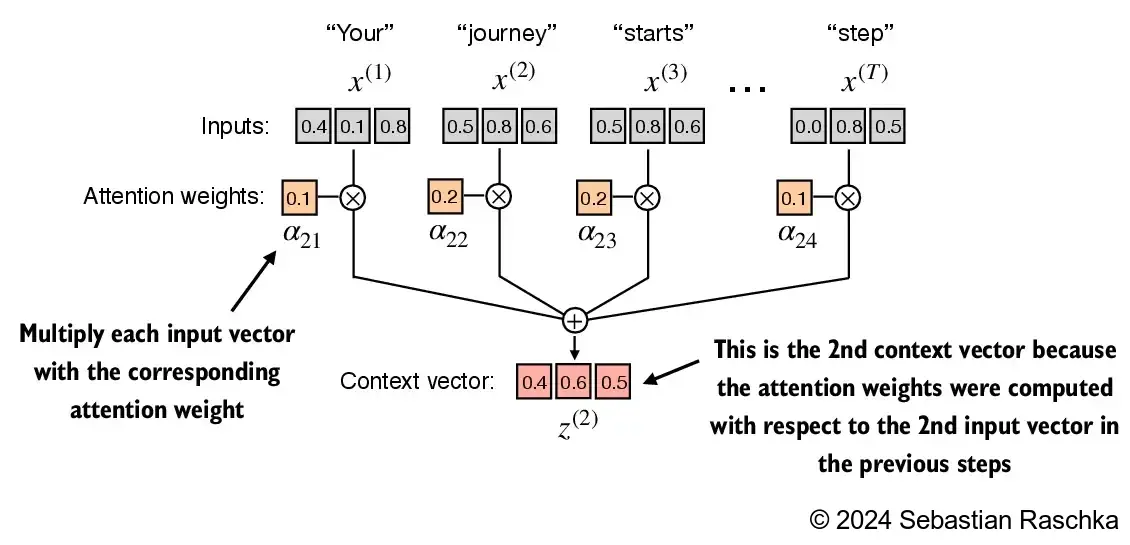

In [15]:

query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
temp=0
print(context_vec_2)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i
    print(context_vec_2)


print(context_vec_2)

tensor([0., 0., 0.])
tensor([0.0596, 0.0208, 0.1233])
tensor([0.1904, 0.2277, 0.2803])
tensor([0.3234, 0.4260, 0.4296])
tensor([0.3507, 0.4979, 0.4705])
tensor([0.4340, 0.5250, 0.4813])
tensor([0.4419, 0.6515, 0.5683])
tensor([0.4419, 0.6515, 0.5683])


# 3.3.2 Computing attention weights for all input tokens


#### Generalize to all input sequence tokens:

* Above, we computed the attention weights and context vector for input 2 (as illustrated in the highlighted row in the figure below)
* Next, we are generalizing this computation to compute all attention weights and context vectors

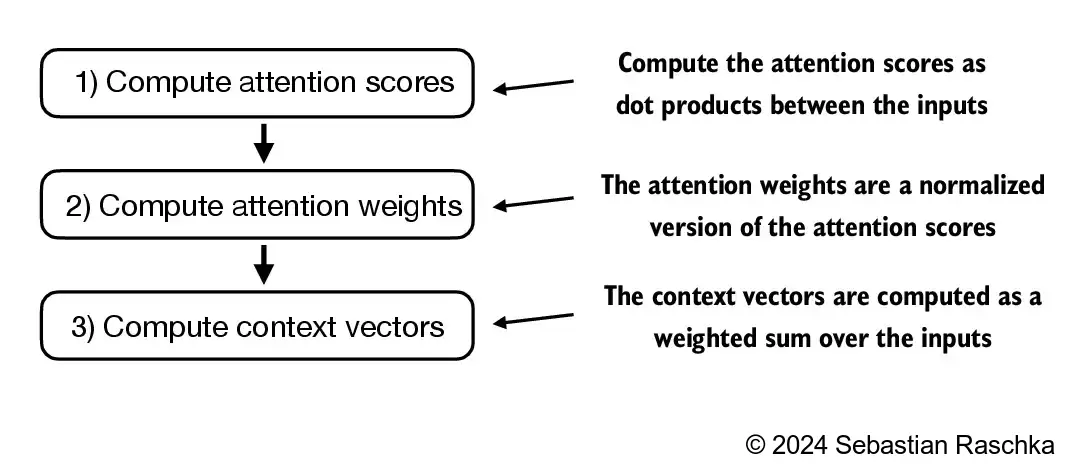

In [18]:
attn_scores = torch.empty(6,6)

for i, x_i in enumerate(inputs):
    for j, j_i in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, j_i)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [20]:
type(attn_scores)

torch.Tensor

* We can achieve the same as above more efficiently via matrix multiplication:

In [21]:
attn_scores = inputs @ inputs.T

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [22]:
attn_weights = torch.softmax(attn_scores, dim = -1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [23]:
all_context_vecs = attn_weights @ inputs

print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


#  3.4 Implementing self-attention with trainable weights

* A conceptual framework illustrating how the self-attention mechanism developed in this section integrates into the overall narrative and structure of this book and chapte


* In this section, we are implementing the self-attention mechanism that is used in the original transformer architecture, the GPT models, and most other popular LLMs
* This self-attention mechanism is also called "scaled dot-product attention"
* The overall idea is similar to before:
  * We want to compute context vectors as weighted sums over the    input vectors specific to a certain input element
  * For the above, we need attention weights
* As you will see, there are only slight differences compared to the basic attention mechanism introduced earlier:
  * The most notable difference is the introduction of weight matrices that are updated during model training
  * These trainable weight matrices are crucial so that the model (specifically, the attention module inside the model) can learn to produce "good" context vectors

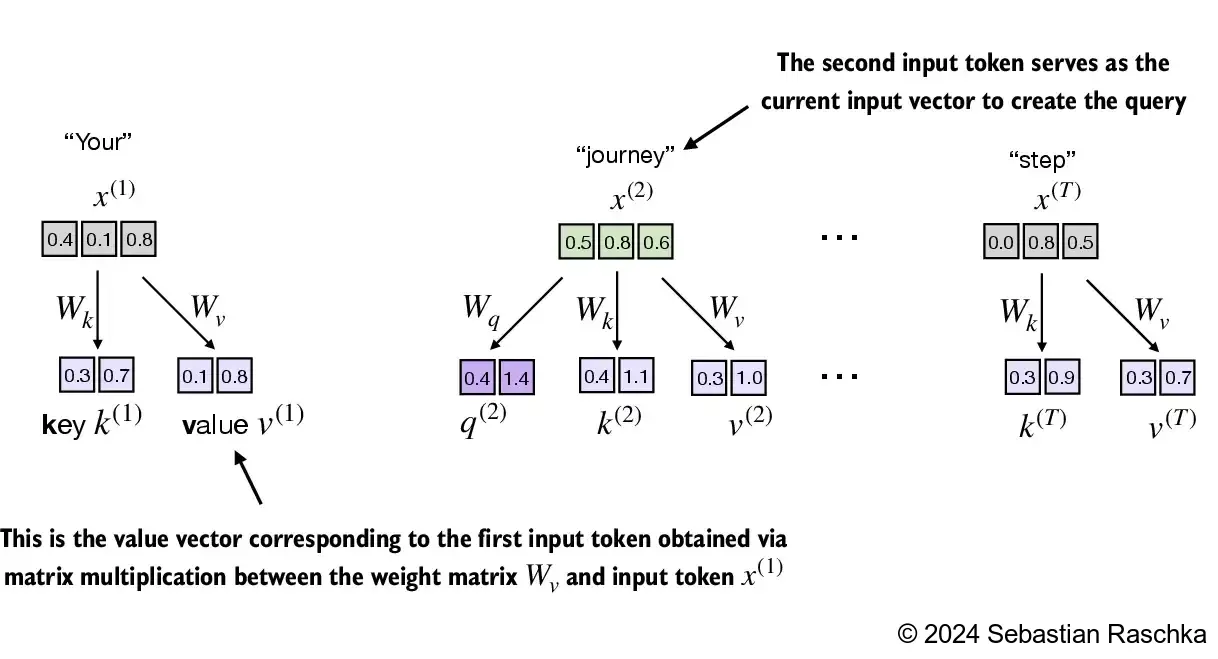

* Implementing the self-attention mechanism step by step, we will start by introducing the three training weight matrices $W_q$, $W_k$, and $W_v$\n",

* These three matrices are used to project the embedded input tokens, $x^{(i)}$, into query, key, and value vectors via matrix multiplication:\n",
    "\n",
    * Query vector: $q^{(i)} = W_q \\,x^{(i)}$\n",
    * Key vector: $k^{(i)} = W_k \\,x^{(i)}$\n",
    * Value vector: $v^{(i)} = W_v \\,x^{(i)}$\n"


* The embedding dimensions of the input x and the query vector r can be the same or different, depending on the model's design and specific implementation
 
* In GPT models, the input and output dimensions are usually the same, but for illustration purposes, to better follow the computation, we choose different input and output dimensions here: